## About Dataset

This Kaggle dataset provides monthly consumption data of petroleum products in India from April 2020 to February 2023. The dataset includes various types of petroleum products, each categorized under specific product labels, such as:

**Aviation Turbine Fuel (ATF)**
**Bitumen** 
**Furnace Oil (FO) & Low-Sulphur Heavy Stock (LSHS)**
**High-Speed Diesel (HSD)**
**Light Diesel Oil (LDO)**
**Liquefied Petroleum Gas (LPG)**
**Lubricants & Greases**
**Motor Spirit (MS)**
**Naptha**
**Others**
**Petroleum Coke**
**Superior Kerosene Oil (SKO)**


In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [28]:
df = pd.read_csv("petroleum_prod_consumption.csv")
df

,month,year,products,quantity_in_1000_metric_tonnes
0,February,2023,ATF,622.73
1,January,2023,ATF,667.36
2,December,2022,ATF,659.00
3,November,2022,ATF,617.63
4,October,2022,ATF,615.78
...,...,...,...,...
415,August,2020,SKO,132.00
416,July,2020,SKO,161.00
417,June,2020,SKO,161.00
418,May,2020,SKO,181.00


In [29]:
print(df.describe())
print()
print(df.info())

              year  quantity_in_1000_metric_tonnes
count   420.000000                      420.000000
mean   2021.200000                     1423.327333
std       0.889074                     1749.788125
min    2020.000000                       23.240000
25%    2020.000000                      354.935000
50%    2021.000000                      827.245000
75%    2022.000000                     1834.250000
max    2023.000000                     7786.430000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   month                           420 non-null    object 
 1   year                            420 non-null    int64  
 2   products                        420 non-null    object 
 3   quantity_in_1000_metric_tonnes  420 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 13.3+ KB
None


In [30]:
df.products.value_counts() # Products are balanced.
product_type = list(df.products.unique()); product_type

['ATF',
 'Bitumen',
 'FO & LSHS',
 'HSD',
 'LDO',
 'LPG',
 'Lubricants & Greases',
 'MS',
 'Naphtha',
 'Others',
 'Petroleum coke',
 'SKO']

In [31]:
yearly_product_consumption = df.groupby(['year', 'products'])['quantity_in_1000_metric_tonnes'].sum().reset_index()
yearly_product_consumption.head(5)

,year,products,quantity_in_1000_metric_tonnes
0,2020,ATF,2352.0
1,2020,Bitumen,4840.0
2,2020,FO & LSHS,4089.0
3,2020,HSD,52113.0
4,2020,LDO,577.0


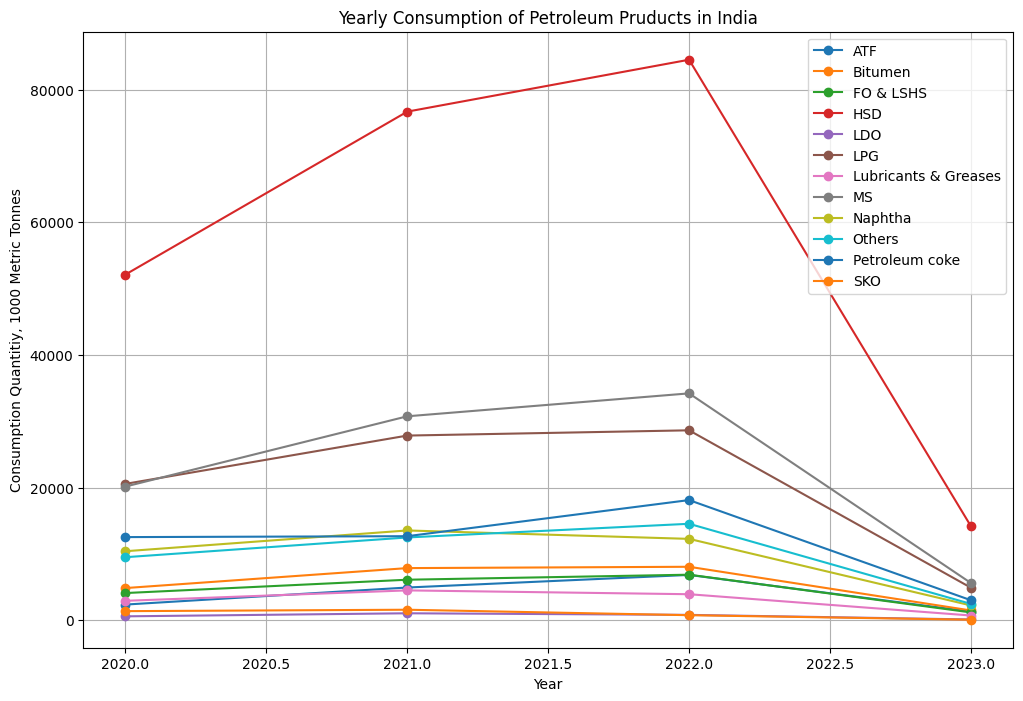

In [32]:
plt.figure(figsize = (12, 8))
for product in yearly_product_consumption["products"].unique() :
    product_data = yearly_product_consumption[yearly_product_consumption['products'] == product]
    plt.plot(product_data["year"], product_data["quantity_in_1000_metric_tonnes"], marker ="o", label = product)
plt.title("Yearly Consumption of Petroleum Pruducts in India")
plt.xlabel("Year")
plt.ylabel("Consumption Quantitiy, 1000 Metric Tonnes")
plt.legend()
plt.grid(True)
plt.savefig("Yearly_Consumption")  # save the graph
plt.show()

In [33]:
# The total petroleum consumption for each year across all products.

total_consumption_yearly = df.groupby("year")["quantity_in_1000_metric_tonnes"].sum().reset_index()
total_consumption_yearly

,year,quantity_in_1000_metric_tonnes
0,2020,141357.00
1,2021,199875.00
2,2022,219412.75
3,2023,37152.73


In [34]:
#Consmption of each product for each year.

consumtion_yearly_pivot = yearly_product_consumption.pivot_table(index = "year", columns = "products", values = "quantity_in_1000_metric_tonnes")
consumtion_yearly_pivot

products,ATF,Bitumen,FO & LSHS,HSD,LDO,LPG,Lubricants & Greases,MS,Naphtha,Others,Petroleum coke,SKO
year,,,,,,,,,,,,
2020,2352.00,4840.00,4089.00,52113.00,577.00,20550.00,2919.00,20146.00,10394.00,9493.00,12524.00,1360.00
2021,4922.00,7850.00,6097.00,76677.00,1038.00,27833.00,4489.00,30740.00,13526.00,12469.00,12661.00,1573.00
2022,6821.59,8049.95,6856.08,84505.11,799.32,28626.19,3911.84,34195.86,12257.56,14532.31,18107.15,749.79
2023,1290.09,1459.81,1169.69,14176.91,106.51,4897.84,702.15,5603.86,2219.94,2451.48,3007.87,66.58


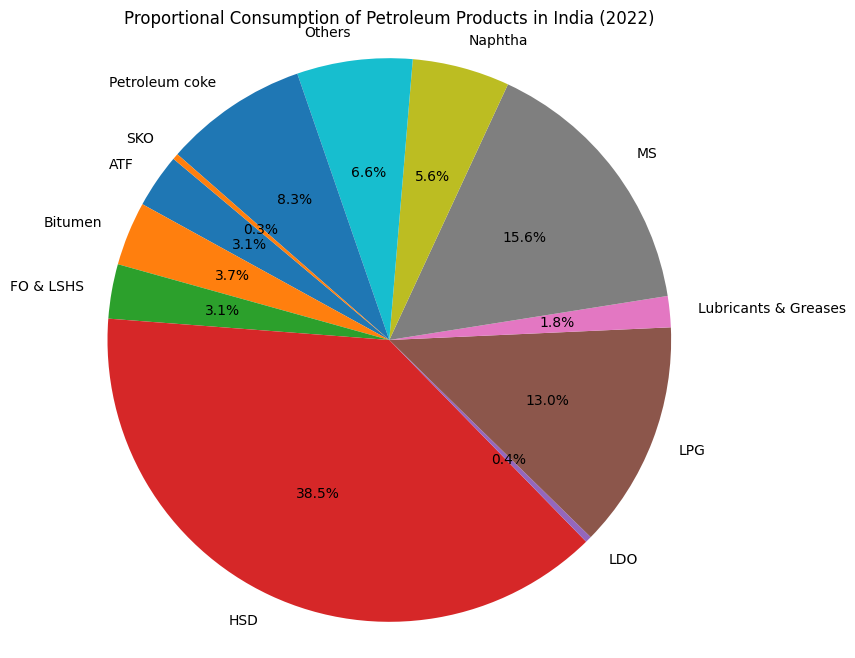

In [35]:
# Pie chart for 2022 Consumption Quantities
df_2022 = df[df['year'] == 2022]
product_consumption_2022 = df_2022.groupby('products')['quantity_in_1000_metric_tonnes'].sum()
plt.figure(figsize=(8, 8))
plt.pie(product_consumption_2022, labels=product_consumption_2022.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportional Consumption of Petroleum Products in India (2022)')
plt.axis('equal')
plt.savefig("2022_Consumption")
plt.show()

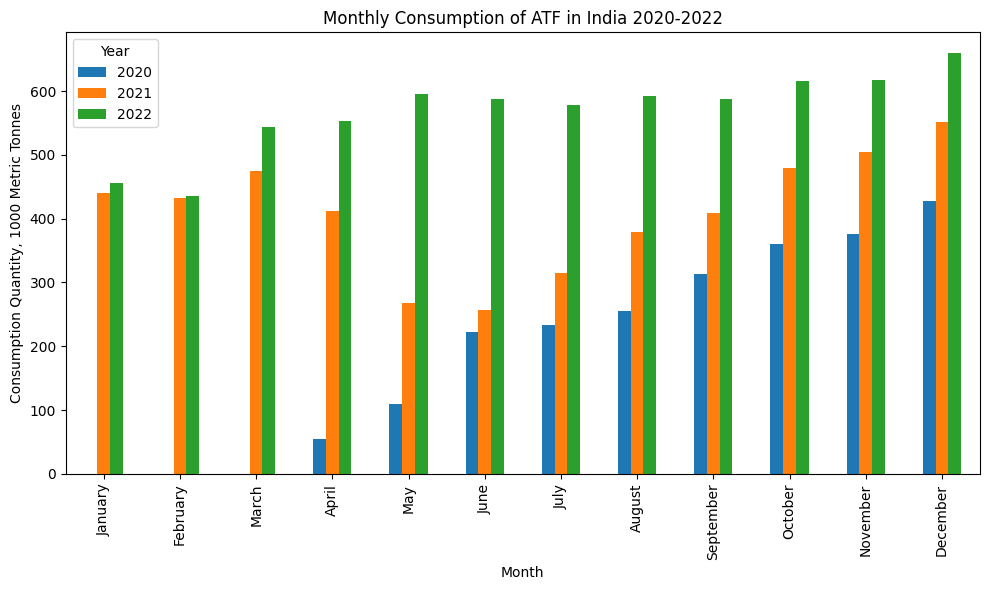

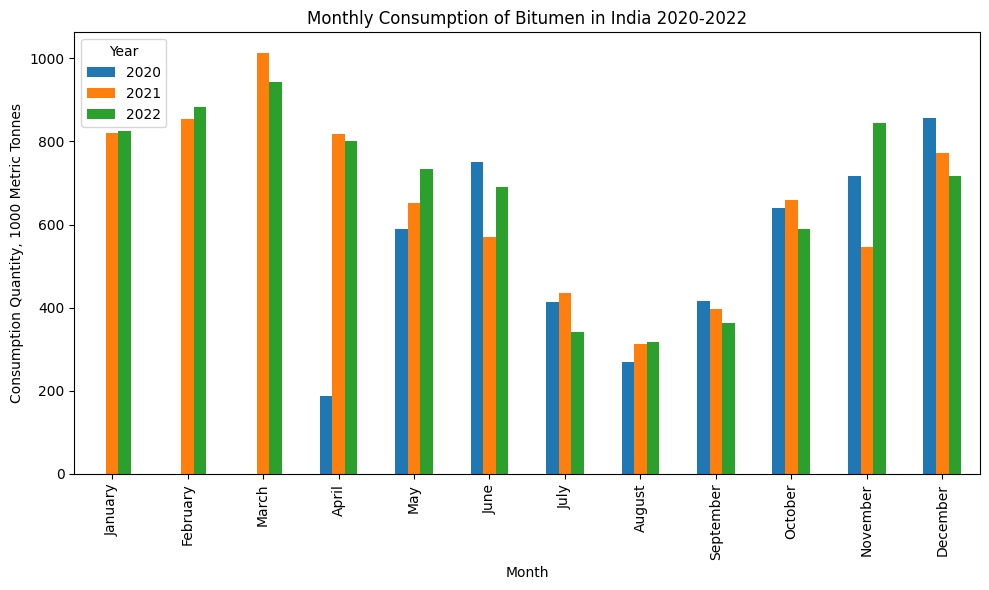

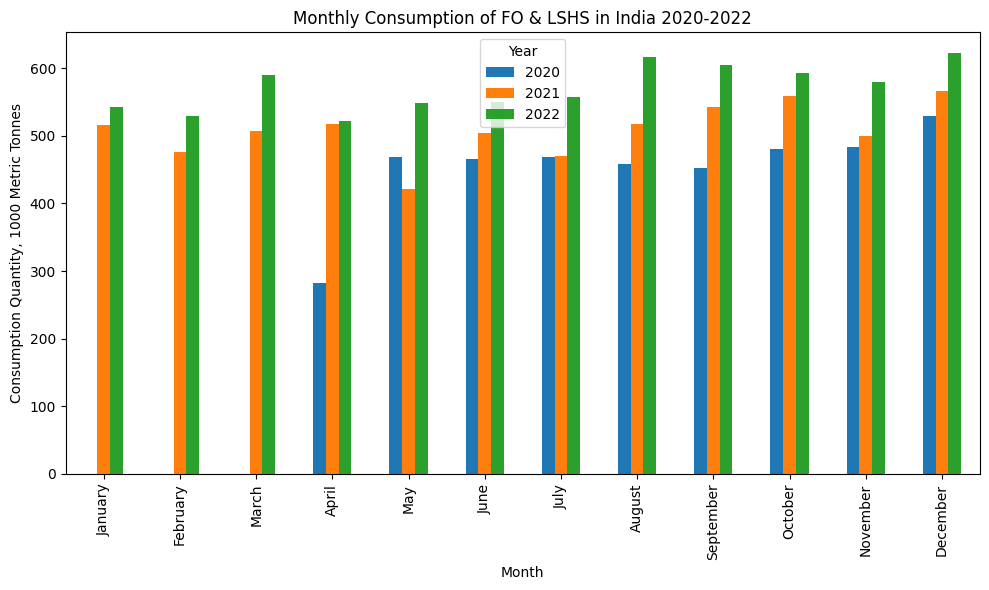

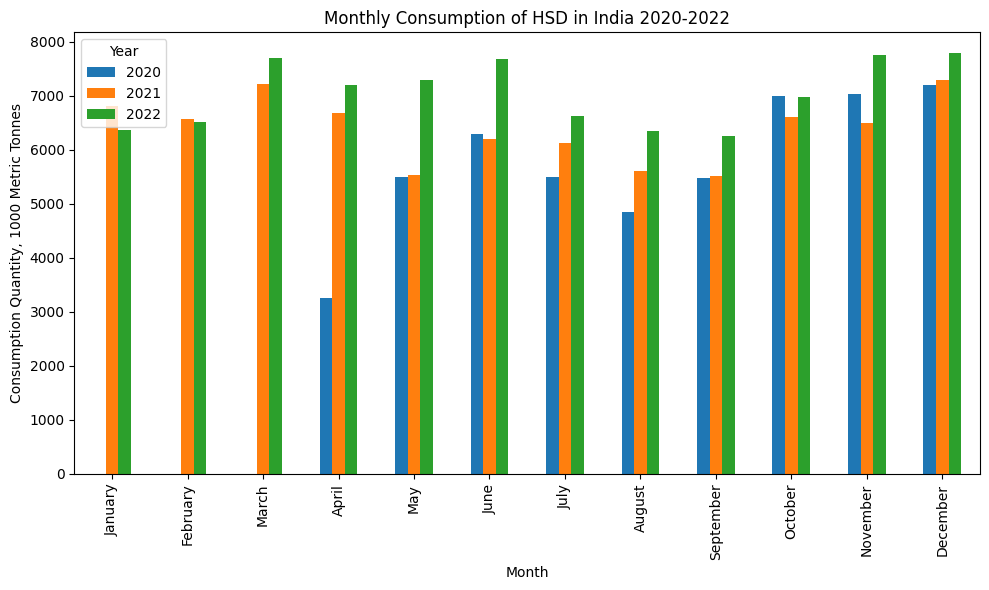

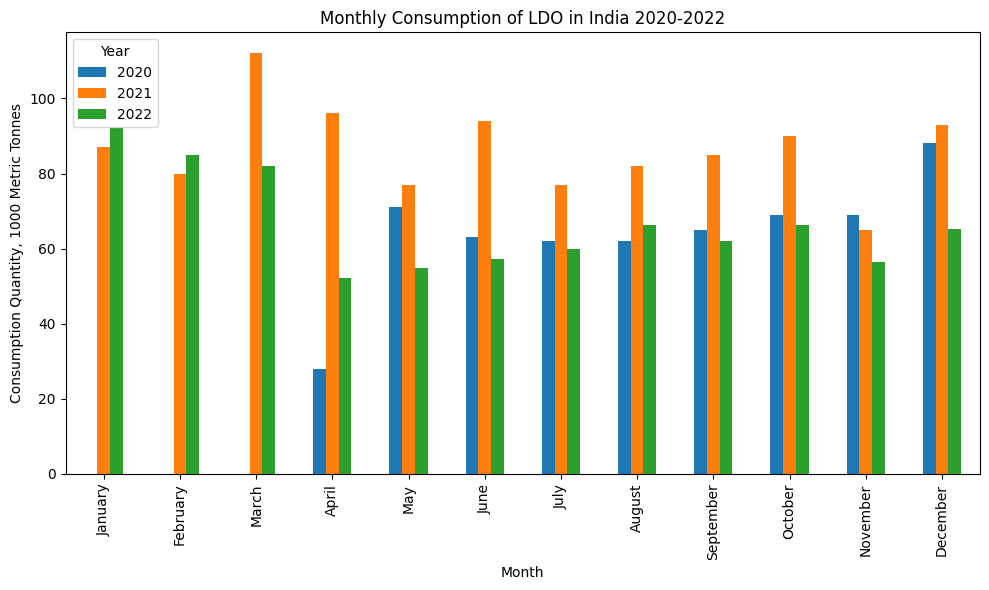

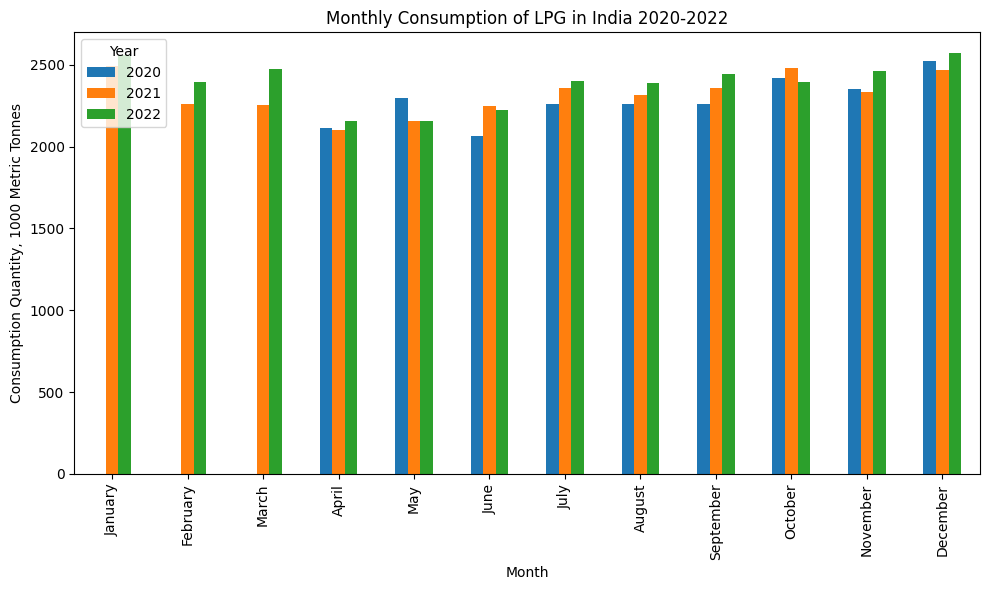

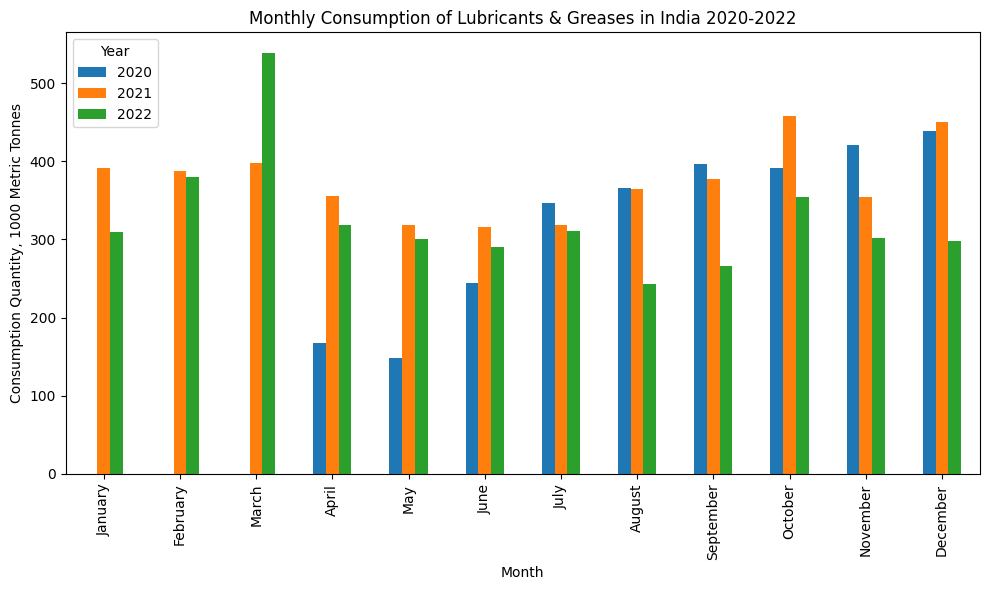

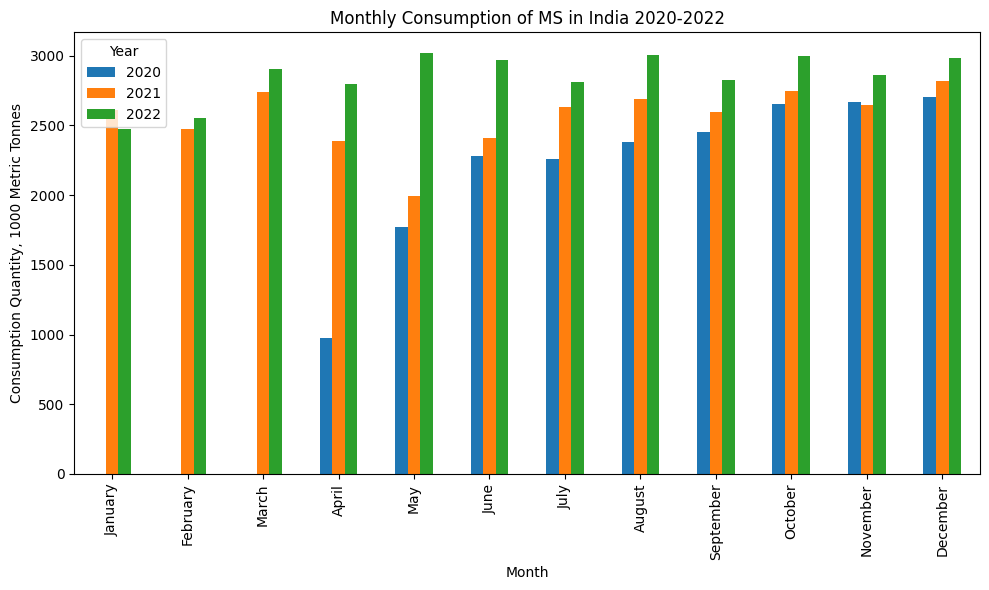

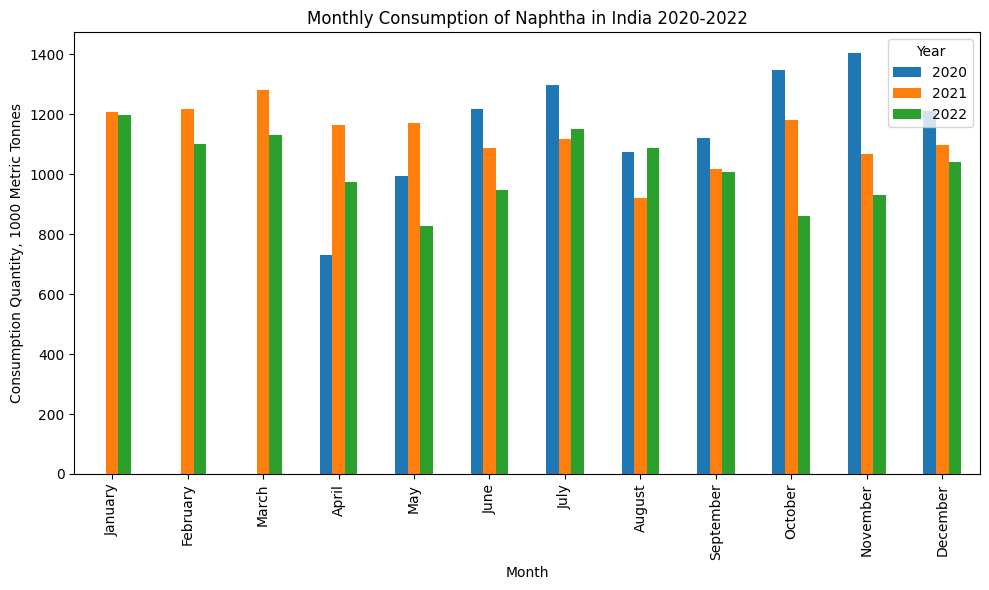

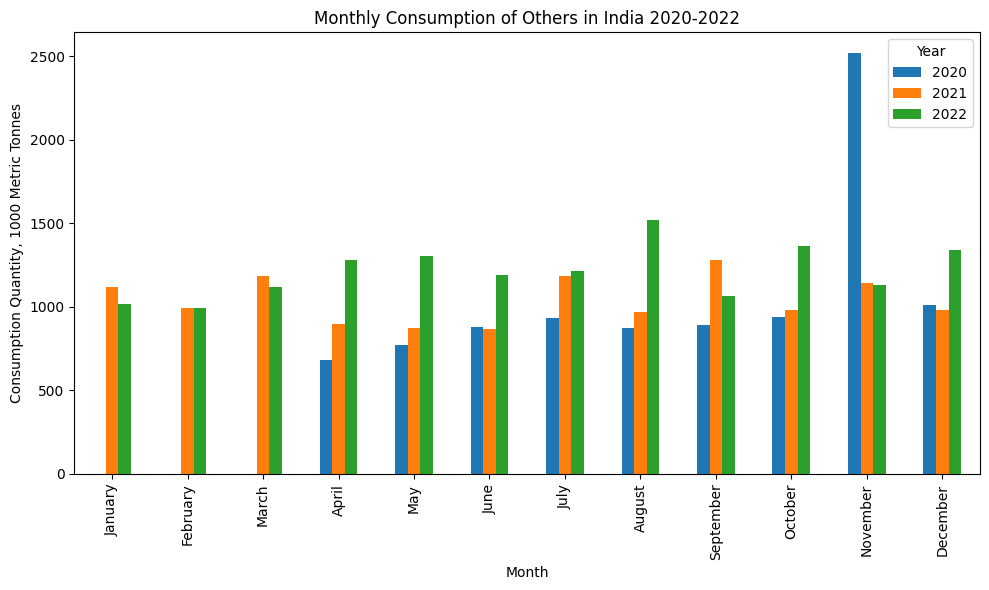

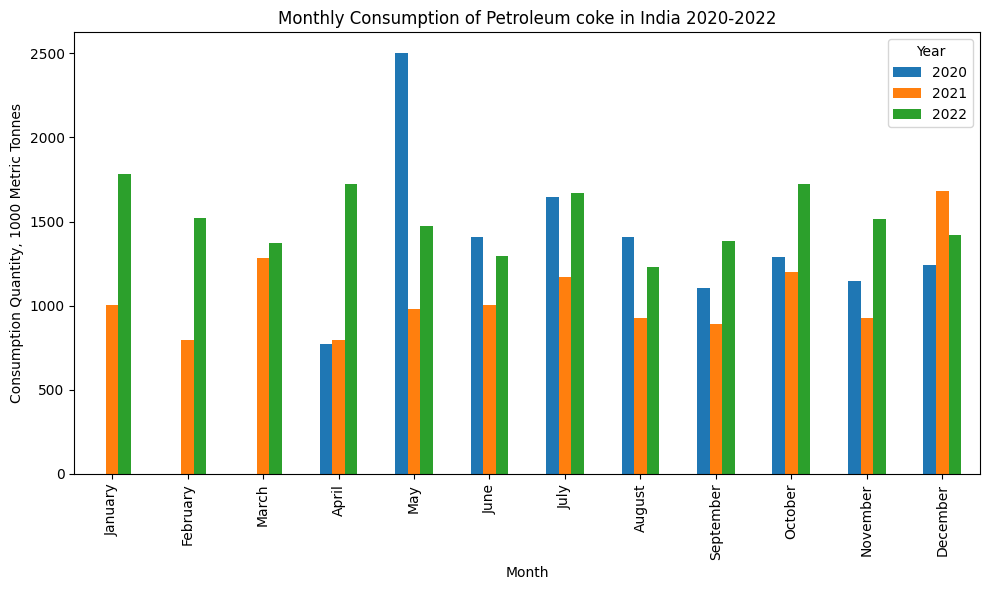

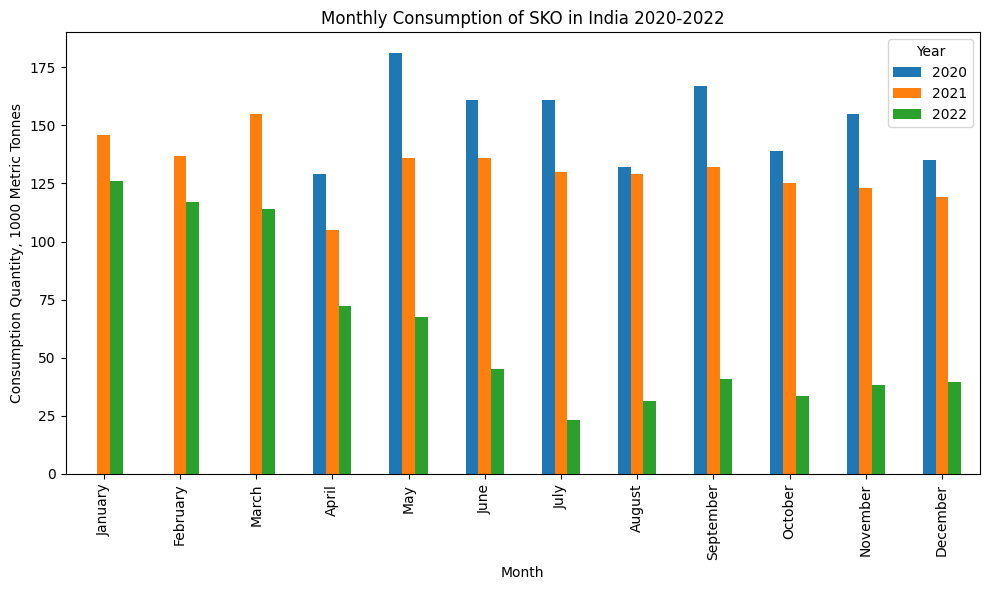

In [36]:
# Comparing monthly consumption of each product for each year (2020, 2021, 2022)

df_filtered = df[df["year"].isin([2020, 2021, 2022])]

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for product in df_filtered["products"].unique():
    product_data_month = df_filtered[df_filtered["products"]==product]
    monthly_consumption = product_data_month.pivot_table(index = "month", columns = "year", values = "quantity_in_1000_metric_tonnes")
    monthly_consumption = monthly_consumption.reindex(month_order)
    monthly_consumption = monthly_consumption.sort_index(axis=1)

    monthly_consumption.plot(kind = "bar", figsize=(10, 6))
    plt.title(f"Monthly Consumption of {product} in India 2020-2022")
    plt.xlabel("Month")
    plt.ylabel("Consumption Quantity, 1000 Metric Tonnes")
    plt.legend(title = "Year")
    plt.tight_layout()
    plt.savefig(f"{product}_consumption.png")  # save the graph
    plt.show()


## PREPARING THE DATETIME DATASET TO THE MODEL
*** Create a 'date' column by combining 'year' and 'month', convert it to datetime, set it as the index, 
resample the data to monthly frequency, and fill missing values. *** 

In [37]:
# Create a 'date' column by combining 'year' and 'month', convert it to datetime, set it as the index, 
# resample the data to monthly frequency, and fill missing values.

df = pd.read_csv("petroleum_prod_consumption.csv")
month_dict = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12}
    
df['month_num'] = df['month'].map(month_dict)
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month_num'].astype(str) + '-01')
df = df.set_index('date')
df = df.resample('MS').sum()
df['quantity_in_1000_metric_tonnes'] = df['quantity_in_1000_metric_tonnes'].interpolate()
display(df.head())

,month,year,products,quantity_in_1000_metric_tonnes,month_num
date,,,,,
2020-04-01,AprilAprilAprilAprilAprilAprilAprilAprilAprilA...,24240,ATFBitumenFO & LSHSHSDLDOLPGLubricants & Greas...,9373.0,48
2020-05-01,MayMayMayMayMayMayMayMayMayMayMayMay,24240,ATFBitumenFO & LSHSHSDLDOLPGLubricants & Greas...,15392.0,60
2020-06-01,JuneJuneJuneJuneJuneJuneJuneJuneJuneJuneJuneJune,24240,ATFBitumenFO & LSHSHSDLDOLPGLubricants & Greas...,16059.0,72
2020-07-01,JulyJulyJulyJulyJulyJulyJulyJulyJulyJulyJulyJuly,24240,ATFBitumenFO & LSHSHSDLDOLPGLubricants & Greas...,15587.0,84
2020-08-01,AugustAugustAugustAugustAugustAugustAugustAugu...,24240,ATFBitumenFO & LSHSHSDLDOLPGLubricants & Greas...,14390.0,96


## DATA AUGMENTATION

In [38]:
# DATA AUGMENTATION
# Determine the standard deviation of the original data
original_std = df['quantity_in_1000_metric_tonnes'].std()

# Define the percentage of the original standard deviation for the noise
noise_percentage = 0.03  # 3%

# Calculate the standard deviation for the noise
noise_std = original_std * noise_percentage

# Generate random normal distributed noise with the calculated standard deviation and the same shape as the original data
noise = np.random.normal(0, noise_std, size=df['quantity_in_1000_metric_tonnes'].shape)

# Add the generated noise to the original time series data
df['quantity_with_noise'] = df['quantity_in_1000_metric_tonnes'] + noise

# Display the head of the DataFrame to show the new column
display(df.head())

,month,year,products,quantity_in_1000_metric_tonnes,month_num,quantity_with_noise
date,,,,,,
2020-04-01,AprilAprilAprilAprilAprilAprilAprilAprilAprilA...,24240,ATFBitumenFO & LSHSHSDLDOLPGLubricants & Greas...,9373.0,48,9342.514478
2020-05-01,MayMayMayMayMayMayMayMayMayMayMayMay,24240,ATFBitumenFO & LSHSHSDLDOLPGLubricants & Greas...,15392.0,60,15444.392466
2020-06-01,JuneJuneJuneJuneJuneJuneJuneJuneJuneJuneJuneJune,24240,ATFBitumenFO & LSHSHSDLDOLPGLubricants & Greas...,16059.0,72,16124.211523
2020-07-01,JulyJulyJulyJulyJulyJulyJulyJulyJulyJulyJulyJuly,24240,ATFBitumenFO & LSHSHSDLDOLPGLubricants & Greas...,15587.0,84,15462.347442
2020-08-01,AugustAugustAugustAugustAugustAugustAugustAugu...,24240,ATFBitumenFO & LSHSHSDLDOLPGLubricants & Greas...,14390.0,96,14354.190874


## NORMALIZATION

In [39]:
# NORMALIZATION with MinMaxScaler on augmanted noisy data

from sklearn.preprocessing import MinMaxScaler

# Select the data for the LSTM model
data_lstm = df['quantity_with_noise'].values

# Reshape the data into a 2D NumPy array
data_lstm = data_lstm.reshape(-1, 1)

# Instantiate the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data using the scaler
scaled_data = scaler.fit_transform(data_lstm)

# Define the create_dataset function
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])                 
    return np.array(X), np.array(y)    

# Apply the create_dataset function with a look-back of 12
look_back = 12
X, y = create_dataset(scaled_data, look_back)

# Reshape the input data X into the format expected by LSTM layers (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print("Data prepared for LSTM:")
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Data prepared for LSTM:
Shape of X: (23, 12, 1)
Shape of y: (23,)


### DEEP LEARNING LSTM MODELING

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Instantiate a Sequential model
model = Sequential()

# Add an LSTM layer
model.add(LSTM(50, input_shape=(look_back, 1)))

# Add a Dense output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train the LSTM model
model.fit(X, y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
23/23 - 0s - 20ms/step - loss: 0.2730
Epoch 2/100
23/23 - 0s - 1ms/step - loss: 0.0352
Epoch 3/100
23/23 - 0s - 1ms/step - loss: 0.0198
Epoch 4/100
23/23 - 0s - 1ms/step - loss: 0.0177
Epoch 5/100
23/23 - 0s - 1ms/step - loss: 0.0172
Epoch 6/100
23/23 - 0s - 1ms/step - loss: 0.0185
Epoch 7/100
23/23 - 0s - 1ms/step - loss: 0.0193
Epoch 8/100
23/23 - 0s - 1ms/step - loss: 0.0168
Epoch 9/100
23/23 - 0s - 1ms/step - loss: 0.0181
Epoch 10/100
23/23 - 0s - 1ms/step - loss: 0.0198
Epoch 11/100
23/23 - 0s - 2ms/step - loss: 0.0175
Epoch 12/100
23/23 - 0s - 2ms/step - loss: 0.0185
Epoch 13/100
23/23 - 0s - 2ms/step - loss: 0.0174
Epoch 14/100
23/23 - 0s - 1ms/step - loss: 0.0179
Epoch 15/100
23/23 - 0s - 1ms/step - loss: 0.0164
Epoch 16/100
23/23 - 0s - 1ms/step - loss: 0.0162
Epoch 17/100
23/23 - 0s - 1ms/step - loss: 0.0192
Epoch 18/100
23/23 - 0s - 1ms/step - loss: 0.0154
Epoch 19/100
23/23 - 0s - 1ms/step - loss: 0.0173
Epoch 20/100
23/23 - 0s - 1ms/step - loss: 0.0166
Epoch 21

### Generating predictions using the trained LSTM model and inverse transform them to the original scale.

In [42]:
# Generate predictions using the trained model
lstm_predictions_scaled = model.predict(X)

# Inverse transform the predictions to the original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Inverse transform the actual values for comparison
y_actual = scaler.inverse_transform(y.reshape(-1, 1))

# Print the shapes of the predictions and actual values
print("Shape of LSTM predictions:", lstm_predictions.shape)
print("Shape of actual values:", y_actual.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Shape of LSTM predictions: (23, 1)
Shape of actual values: (23, 1)


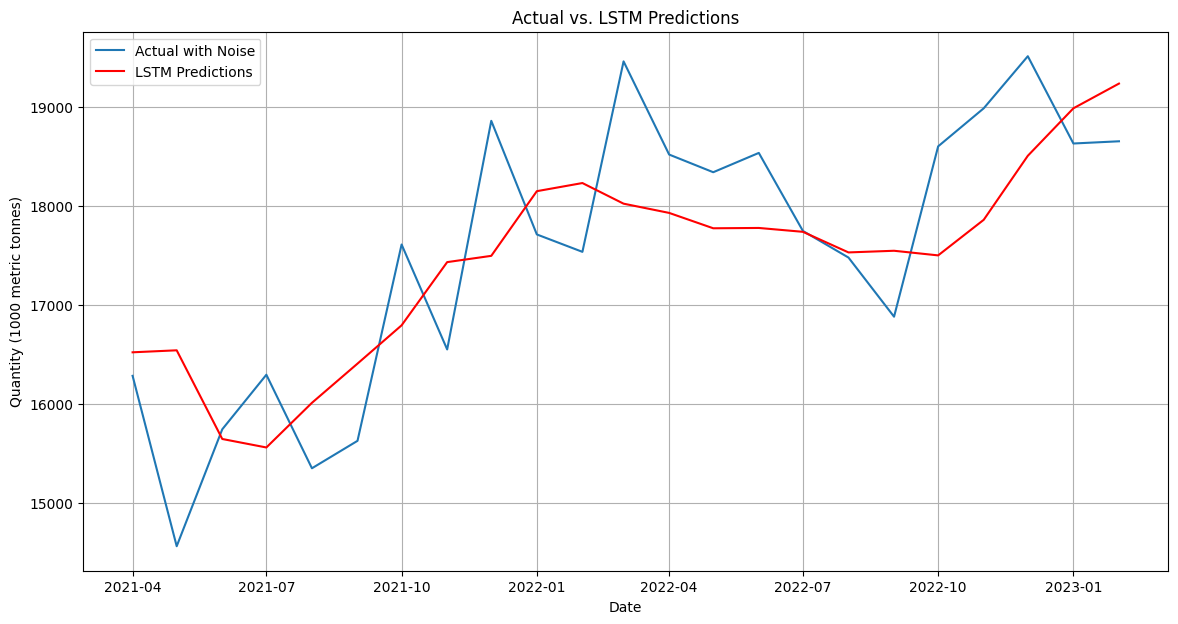

In [43]:
# Visualizing the actual values and the LSTM predictions to evaluate the model's performance.

# Create a DataFrame for plotting
lstm_plot_data = df.iloc[look_back:].copy()
lstm_plot_data['LSTM Predictions'] = lstm_predictions

# Plot the actual values and LSTM predictions
plt.figure(figsize=(14, 7))
plt.plot(lstm_plot_data.index, lstm_plot_data['quantity_with_noise'], label='Actual with Noise')
plt.plot(lstm_plot_data.index, lstm_plot_data['LSTM Predictions'], label='LSTM Predictions', color='red')

plt.title('Actual vs. LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Quantity (1000 metric tonnes)')
plt.legend()
plt.grid(True)
plt.savefig("Predict_Evaluate")  # save the graph
plt.show()

## FEATURE PREDICTION
Generate future predictions using the trained LSTM model, prepare the input data for future prediction, inverse transform the predictions, and store them in a variable.

In [44]:
# Calculate and print the Mean Squared Error (MSE) and R-squared score to evaluate the LSTM model's performance.

# Calculate MSE
lstm_mse = mean_squared_error(y_actual, lstm_predictions)

# Calculate R-squared
lstm_r2 = r2_score(y_actual, lstm_predictions)

# Print the evaluation metrics
print(f'LSTM Model Mean Squared Error (MSE) on training data: {lstm_mse}')
print(f'LSTM Model R-squared (R2) on training data: {lstm_r2}')

LSTM Model Mean Squared Error (MSE) on training data: 747636.2266540987
LSTM Model R-squared (R2) on training data: 0.5960257491057264


In [45]:
# Generate future predictions using the trained LSTM model, prepare the input data for future prediction, 
# inverse transform the predictions, and store them in a variable.

# Prepare the input sequence for future prediction
last_sequence = scaled_data[-look_back:].reshape(1, look_back, 1)

# Generate future predictions for the next 12 months
future_lstm_predictions_scaled = []
current_sequence = last_sequence

for _ in range(12):
    # Predict the next step
    next_prediction_scaled = model.predict(current_sequence, verbose=0)
    future_lstm_predictions_scaled.append(next_prediction_scaled[0, 0])

    # Update the input sequence: remove the first element and add the predicted element
    current_sequence = np.append(current_sequence[:, 1:, :], next_prediction_scaled.reshape(1, 1, 1), axis=1)

# Inverse transform the generated future predictions
future_lstm_predictions = scaler.inverse_transform(np.array(future_lstm_predictions_scaled).reshape(-1, 1))

# Store the future predictions in a variable
# The future_lstm_predictions variable already holds the inverse-transformed predictions.
print("Future LSTM predictions generated.")

Future LSTM predictions generated.


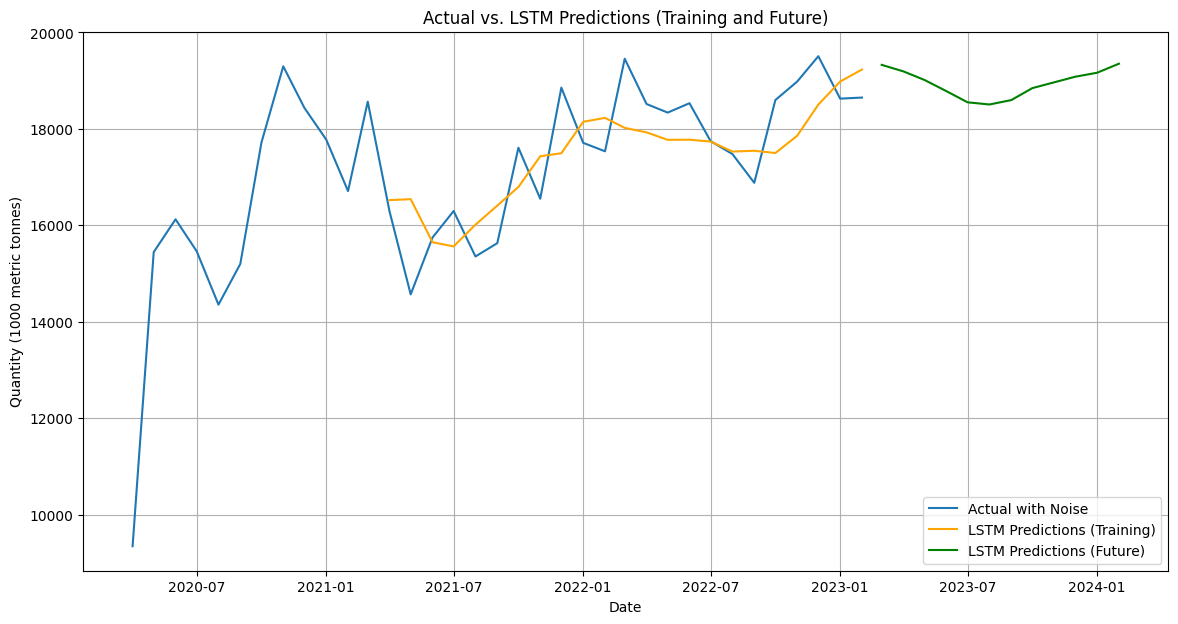

In [46]:
# Visualizing the future and training LSTM predictions on a single plot to assess the model's performance and its forecast.

# Create date indices for future predictions
last_date_train = df.index[-1]
future_dates = pd.date_range(start=last_date_train + pd.DateOffset(months=1), periods=12, freq='MS')

# Create a pandas Series for future predictions
future_lstm_predictions_series = pd.Series(future_lstm_predictions.flatten(), index=future_dates)

# Plot the actual time series data (with noise)
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['quantity_with_noise'], label='Actual with Noise')

# Plot the LSTM model's predictions on the training data
plt.plot(lstm_plot_data.index, lstm_plot_data['LSTM Predictions'], label='LSTM Predictions (Training)', color='orange')

# Plot the future LSTM predictions
plt.plot(future_lstm_predictions_series.index, future_lstm_predictions_series, label='LSTM Predictions (Future)', color='green')

# Add title and labels
plt.title('Actual vs. LSTM Predictions (Training and Future)')
plt.xlabel('Date')
plt.ylabel('Quantity (1000 metric tonnes)')
plt.legend()
plt.grid(True)
plt.savefig("All_Predict_Evaluate.png") 
plt.show()